In [67]:
from tensorflow import keras
CNN_Model = keras.models.load_model('/Users/joostberkelbach/Documents/Machine Learning/Model Changed Dataset')

In [68]:
TL = keras.models.load_model('/Users/joostberkelbach/Documents/Machine Learning/Transfer Learning/Transfer Learning - Unfreeze last 2 convolution layers')

In [69]:
#import libraries
import numpy as np
import pandas as pd

import os
import random
from operator import itemgetter
import copy
import time

import torch
import torchvision
import torchvision.transforms as transform
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.nn as nn
import torchvision.models as models
from torchvision.utils import make_grid
import torch.nn.functional as F
import cv2
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.image import imread
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop


from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

In [70]:
#Image directories
X = []
Z = []

Image_Size = 150

Daisy_Dir = '/Users/joostberkelbach/Documents/Machine Learning/Assignment 2/flowers/daisy'
Dandelion_Dir = '/Users/joostberkelbach/Documents/Machine Learning/Assignment 2/flowers/dandelion'
Rose_Dir = '/Users/joostberkelbach/Documents/Machine Learning/Assignment 2/flowers/rose'
Sunflower_Dir = '/Users/joostberkelbach/Documents/Machine Learning/Assignment 2/flowers/sunflower'
Tulip_Dir = '/Users/joostberkelbach/Documents/Machine Learning/Assignment 2/flowers/tulip'

In [71]:
#Flower type labeller
def Assign_Label(Image,Flower_Type):
    return Flower_Type

In [72]:
def Make_Train_Data(Flower_Type, Dir):
    for Image in tqdm(os.listdir(Dir)):
        Label = Assign_Label(Image, Flower_Type)
        Path = os.path.join(Dir, Image)
        Image = cv2.imread(Path, cv2.IMREAD_COLOR)
        Image = cv2.resize(Image, (Image_Size, Image_Size))
        
        X.append(np.array(Image))
        Z.append(str(Label))

In [73]:
#Retrieve images
Make_Train_Data('Daisy',Daisy_Dir)
Make_Train_Data('Dandelion', Dandelion_Dir)
Make_Train_Data('Rose', Rose_Dir)
Make_Train_Data('Sunflower', Sunflower_Dir)
Make_Train_Data('Tulip', Tulip_Dir)

100%|██████████| 984/984 [00:02<00:00, 389.38it/s]


In [74]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
Y = LE.fit_transform(Z)
Y = to_categorical(Y,5)
X = np.array(X)
X = X/255

In [75]:
#Split images into train and test set
X_Train,X_Test,Y_Train,Y_Test=train_test_split(X,Y,test_size=0.20,random_state=43)

In [76]:
#Get predictions from transfer learning and CNN on testing set
from numpy import loadtxt
Predictions_CNN_Model =  loadtxt('CNN_Predictions.csv', delimiter=',')
Predictions_TL = TL.predict(X_Test)

In [77]:
#Adding the predictions
Predictions = Predictions_CNN_Model + Predictions_TL

In [78]:
#Determine class of summed prediction
Predictions_digits=np.argmax(Predictions,axis=1)

In [79]:
#Confusion matrix code
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Greens")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

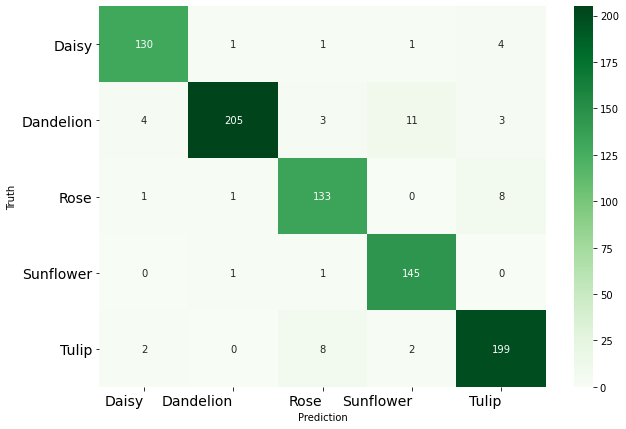

In [80]:
#Building the confusion matrix
obtained = []
truth = []
classes = ['daisy','dandelion','rose','sunflower','tulip']

for i in range(len(Predictions)) : 
    obtained.append(classes[np.argmax(Predictions[i])])
    if Y_Test[i][0]==1:
        truth.append(classes[0])
    elif Y_Test[i][1]==1:
        truth.append(classes[1])
    elif Y_Test[i][2]==1:
        truth.append(classes[2])
    elif Y_Test[i][3]==1:
        truth.append(classes[3])
    elif Y_Test[i][4]==1:
        truth.append(classes[4])

cm = confusion_matrix(truth,obtained)
print_confusion_matrix(cm,['Daisy','Dandelion','Rose','Sunflower','Tulip'])

In [81]:
from sklearn.metrics import f1_score

In [82]:
#F1 score
F1 = f1_score(obtained,truth,average=None)
for i in [0,1,2,3,4]:
    print("F1 score","",classes[i],"     ",F1[i])

F1 score  daisy       0.948905109489051
F1 score  dandelion       0.9447004608294931
F1 score  rose       0.9204152249134948
F1 score  sunflower       0.9477124183006537
F1 score  tulip       0.936470588235294


In [89]:
#Assessment criteria
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("Recall : " + str(TPR))
#print("Overall Reacll : " + str(np.sum(TPR)))
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Precision: " + str(PPV))
#print("Overall Precision : " + str(np.sum(PPV)))
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# Positive likelihood ratio
LR = TPR/FPR

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Accuracy", ACC)
#print("Overall Accuracy: " + str(np.sum(ACC)))



Recall : [0.94890511 0.90707965 0.93006993 0.98639456 0.94312796]
Precision: [0.94890511 0.98557692 0.9109589  0.91194969 0.92990654]
Accuracy [0.9837963  0.97222222 0.97337963 0.98148148 0.96875   ]


In [103]:
truth_value = []

for i in range(len(truth)):
    if truth[i]=='daisy':
        truth_value.append(0)
    elif truth[i]=='dandelion':
        truth_value.append(1)
    elif truth[i]=='rose':
        truth_value.append(2)
    elif truth[i]=='sunflower':
        truth_value.append(3)
    elif truth[i]=='tulip':
        truth_value.append(4)

In [107]:
# Finding the mistakes of combined models
mistakes = []
for i in range(len(truth)):
    if truth_value[i] - Predictions_digits[i] != 0:
        mistakes.append(i)

In [123]:
#Number of images incorrectly classified
len(mistakes)

52

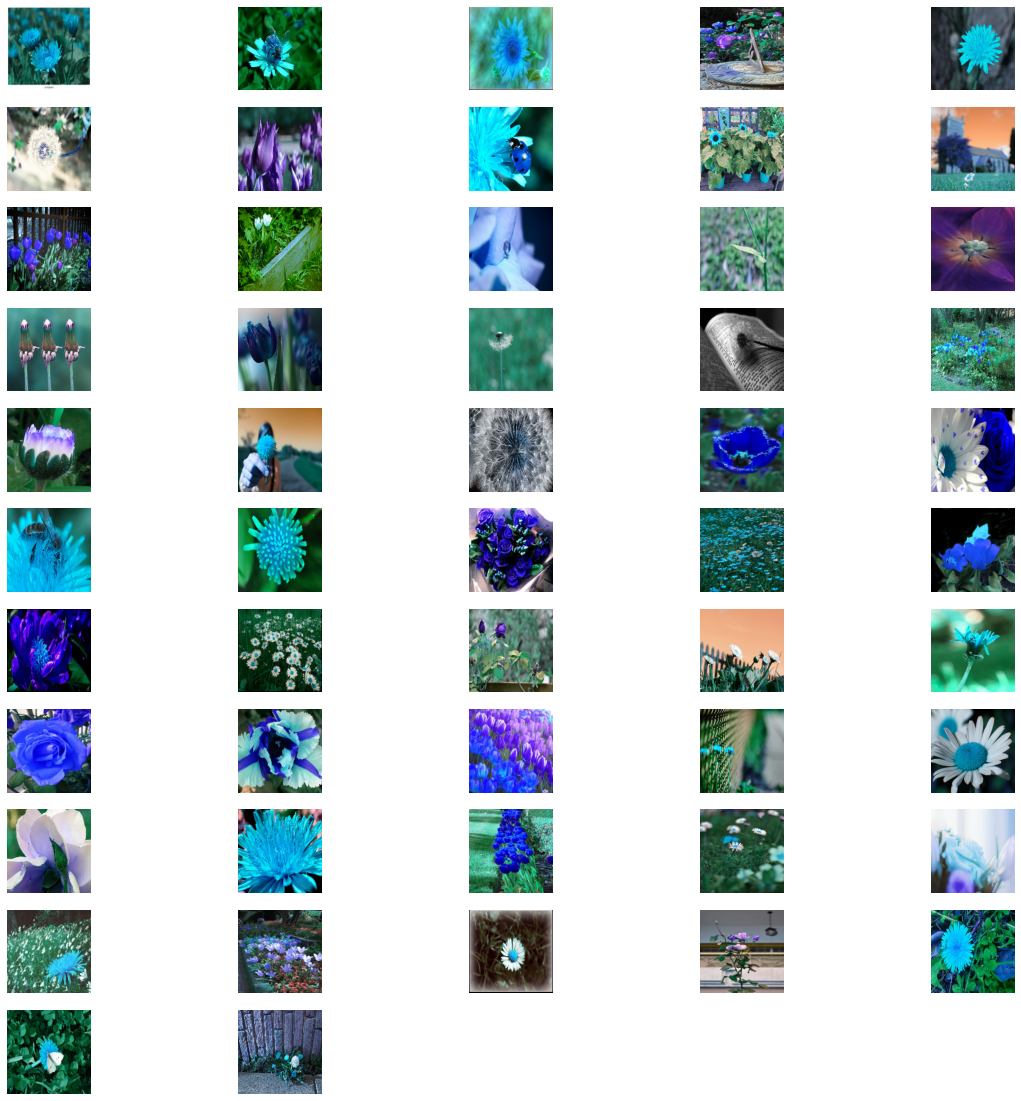

In [128]:
#Print images that are classified incorrectly by combined models
plt.figure(figsize = (20,20))
for i in range(len(mistakes)):
    img = X_Test[mistakes[i]]
    plt.subplot(11,5,i+1)
    plt.imshow(img)
    plt.axis("off")
plt.show()